In [1]:
import time
import os
from os import listdir
from os.path import join, isfile

import numpy as np
import numpy.matlib
import pandas as pd
import pyedflib
from scipy.signal import find_peaks_cwt, welch
from scipy.signal import decimate
from datetime import timedelta
from mne.filter import filter_data

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import signal
from scipy.fft import fft, ifft

In [3]:
pd_id = '110001'


path_c = 'npy_csv'
path_s = 'npy_sec'
trialData = np.load(join('data',path_c, pd_id + '_trials.npy')).astype(np.float64)
secData = np.load(join('data',path_s, '5sec_'+pd_id + '_trials.npy')).astype(np.float64)
esm = pd.read_csv(join('data',path_c, pd_id + '_esm.csv'))



In [4]:
class filtering():
    def __init__(self, bsWn=[49, 51], bpWn = [2, 9], hpWn=1, lpWn = 500,fs=2000):
        self.fs=fs
        self.bandstopWn = bsWn
        self.highpassWn= hpWn
        self.lowpassWn = lpWn 
        nyq = 0.5 * self.fs
        self.bandpassWn = np.array(bpWn)/nyq
       
        
    def downsample(self,data,proportion=0.4):
        return pd.Series(islice(data,0,len(data), int(1/proportion)))
    
    def highpass(self,data,order=5):
        b, a = signal.butter(order, self.highpassWn, 'highpass',fs = self.fs) 
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal

    def lowpass(self,data):
        b, a = signal.butter(4, self.lowpassWn, 'lowpass', fs = self.fs)
        y = lfilter(b, a, data)
        return y
    
    def bandstop(self,data):
        b, a = signal.butter(4, self.bandstopWn, 'bandstop',fs = self.fs)
        outputSignal = signal.lfilter(b, a, data)
        return outputSignal 
    
    def bandpass(self, data): 
        b, a = signal.butter(4, self.bandpassWn, 'bandpass', fs = self.fs)
        outputSignal = signal.lfilter(b, a, data)
        return outputSignal 
        
        
    def rectify(self, to_rectify):
        return abs(to_rectify)    
    
    def cutofftail(self,data, obsCutOffSec=10):
         return data[:-obsCutOffSec * self.fs]
    
    def ADC(self, data):
        return 3.3/8191*data

In [5]:
labels = ['AccXL', 'AccYL', 'AccZL', 'GyrXL', 'GyrYL', 'GyrZL',
          'AccXR', 'AccYR', 'AccZR', 'GyrXR', 'GyrYR','GyrZR',
          'AccXC', 'AccYC', 'AccZC', 'GyrXC', 'GyrYC', 'GyrZC']
# sampling rate:
sr = 100 
trialData.shape[0]


75

In [6]:
esm[esm['tremor']==7][['tremor','slowness','dyskinesia']]

,tremor,slowness,dyskinesia


In [7]:
esm[esm['tremor']==1][['tremor','slowness','dyskinesia']]

,tremor,slowness,dyskinesia
0,1.0,5.0,1.0
1,1.0,5.0,1.0
2,1.0,3.0,1.0
3,1.0,3.0,1.0
4,1.0,3.0,1.0
...,...,...,...
68,1.0,4.0,1.0
70,1.0,4.0,1.0
71,1.0,4.0,1.0
72,1.0,4.0,1.0


In [22]:
esm[esm['tremor']==3][['tremor','slowness','dyskinesia']]

,tremor,slowness,dyskinesia
74,3.0,4.0,1.0


In [9]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


In [23]:
acceleromterFilt = filtering(hpWn = 0.3, bpWn = [0.3 , 9],lpWn = 9, fs=sr)


NFFT = 128 
noverlap = int(0.50*NFFT)
nESM = 74

f_accXL = acceleromterFilt.highpass(trialData[nESM,:,0])
f_accYL = acceleromterFilt.highpass(trialData[nESM,:,1])
f_accZL = acceleromterFilt.highpass(trialData[nESM,:,2])


f_gyrXL = acceleromterFilt.highpass(trialData[nESM,:,3]) 
f_gyrYL = acceleromterFilt.highpass(trialData[nESM,:,4]) 
f_gyrZL = acceleromterFilt.highpass(trialData[nESM,:,5]) 


f_accXR = acceleromterFilt.highpass(trialData[nESM,:,6]) 
f_accYR = acceleromterFilt.highpass(trialData[nESM,:,7]) 
f_accZR = acceleromterFilt.highpass(trialData[nESM,:,8]) 


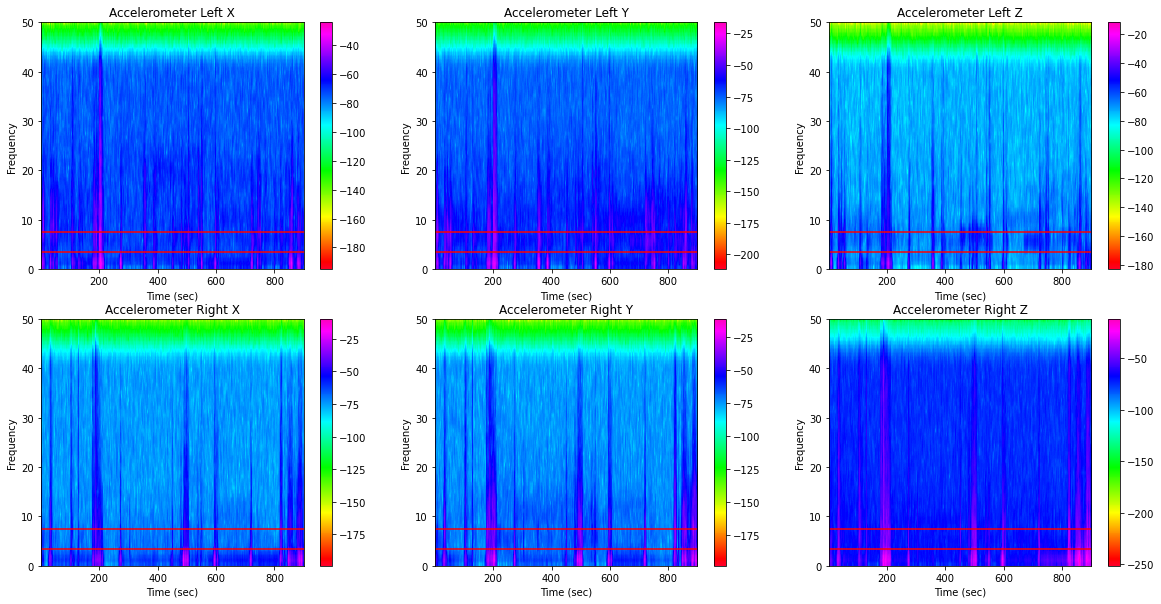

In [24]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
powerSpectrumXL, freqenciesFoundXL, _ , _  =plt.specgram(f_accXL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Left X')
plt.colorbar()

plt.subplot(2,3,2)
powerSpectrumYL, freqenciesFoundYL, _ , _  =plt.specgram(f_accYL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Left Y')
plt.colorbar()

plt.subplot(2,3,3)
powerSpectrumZL, freqenciesFoundZL, _ , _  = plt.specgram(f_accZL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Left Z')
plt.colorbar()

plt.subplot(2,3,4)
powerSpectrumXR, freqenciesFoundXR, _ , _ = plt.specgram(f_accXR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Right X')
plt.colorbar()

plt.subplot(2,3,5)
powerSpectrumYR, freqenciesFoundYR, _, _  = plt.specgram(f_accYR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), 
             cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Right Y')
plt.colorbar()

plt.subplot(2,3,6)
powerSpectrumZR, freqenciesFoundZR,  _, _= plt.specgram(f_accZR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), 
             cmap='gist_rainbow')
plt.axhline(y=3.5, color='r', linestyle='-')
plt.axhline(y=7.5, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Accelerometer Right Z')
plt.colorbar()




In [283]:
imageAxis

In [284]:
subpowerSpectrumXL=powerSpectrumXL[(freqenciesFoundXL < 9) & (freqenciesFoundXL > 0.3),:]
subpowerSpectrumYL=powerSpectrumYL[(freqenciesFoundYL < 9) & (freqenciesFoundYL > 0.3),:]
subpowerSpectrumZL=powerSpectrumZL[(freqenciesFoundZL < 9) & (freqenciesFoundZL > 0.3),:]
subpowerSpectrumXR=powerSpectrumXR[(freqenciesFoundXR < 9) & (freqenciesFoundXR > 0.3),:]
subpowerSpectrumYR=powerSpectrumYR[(freqenciesFoundXR < 9) & (freqenciesFoundXR > 0.3),:]
subpowerSpectrumZR=powerSpectrumZR[(freqenciesFoundZR < 9) & (freqenciesFoundZR > 0.3),:]


subpowerSpectrumXL_= np.mean(subpowerSpectrumXL,axis=0)
subpowerSpectrumYL_= np.mean(subpowerSpectrumYL,axis=0)
subpowerSpectrumZL_= np.mean(subpowerSpectrumZL,axis=0)
subpowerSpectrumXR_= np.mean(subpowerSpectrumXR,axis=0)
subpowerSpectrumYR_= np.mean(subpowerSpectrumYR,axis=0)
subpowerSpectrumZR_= np.mean(subpowerSpectrumZR,axis=0)



test_ = np.row_stack((subpowerSpectrumXL_,
                     subpowerSpectrumYL_,
                     subpowerSpectrumZL_,
                     subpowerSpectrumXR_,
                     subpowerSpectrumYR_,
                     subpowerSpectrumZR_))


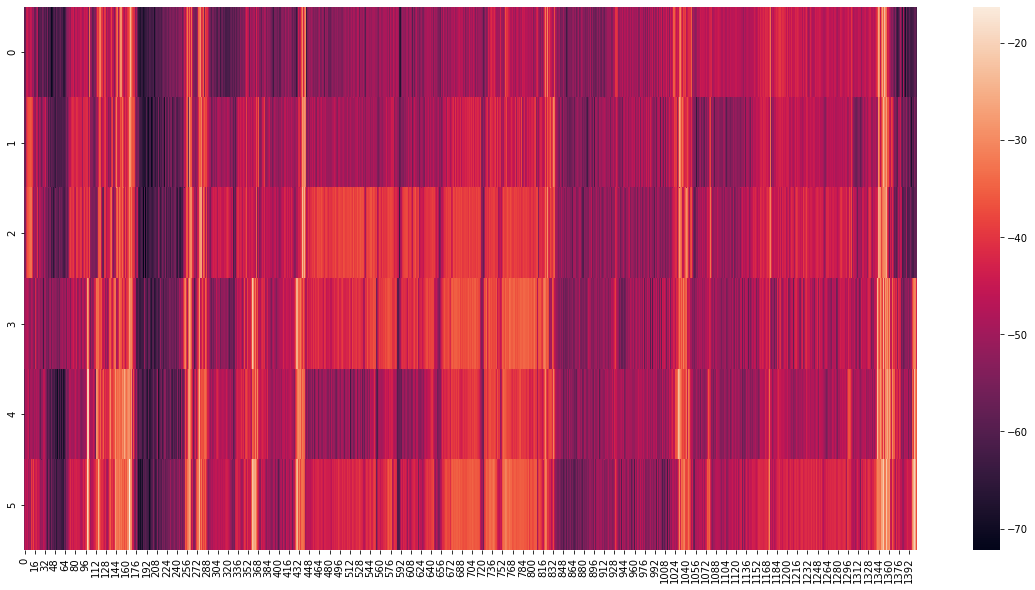

In [285]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(10 * np.log10(test_))